[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pruppacher_and_Rasmussen_1979/fig_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Pruppacher_and_Rasmussen_1979/fig_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pruppacher_and_Rasmussen_1979/fig_1.ipynb)

## based on Fig. 1 in [Pruppacher and Rasmussen 1979](https://doi.org/10.1175/1520-0469(1979)036%3C1255:AWTIOT%3E2.0.CO;2) 

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si, in_unit
from matplotlib import pyplot
from scipy.interpolate import interp1d

In [3]:
formulae = Formulae(
    terminal_velocity="RogersYau",
    isotope_diffusivity_ratios="HellmannAndHarvey2020",
    ventilation="PruppacherAndRasmussen1979",
    particle_shape_and_density="LiquidSpheres",
    air_dynamic_viscosity="ZografosEtAl1987",
)

In [4]:
def f(formulae, radius, temperature):
    eta_air = formulae.air_dynamic_viscosity.eta_air(temperature)
    air_density = formulae.constants.p_STP / formulae.constants.Rd / temperature
    X = formulae.trivia.sqrt_re_times_cbrt_sc(
            Re = formulae.particle_shape_and_density.reynolds_number(
                radius = radius, 
                velocity_wrt_air=formulae.terminal_velocity.v_term(radius), 
                dynamic_viscosity = eta_air, 
                density = air_density
            ), 
            Sc = formulae.trivia.air_schmidt_number(
                dynamic_viscosity=eta_air,
                diffusivity=formulae.diffusion_thermics.D(
                    T=temperature,
                    p=formulae.constants.p_STP),
                density=air_density,
            )
        )
    return X, formulae.ventilation.ventilation_coefficient(X)

In [5]:
def f_heavy(f, temperature, isotope):
    return 1 + (f-1)*(getattr(formulae.isotope_diffusivity_ratios, f"ratio_{isotope}")(temperature))**(1/3)

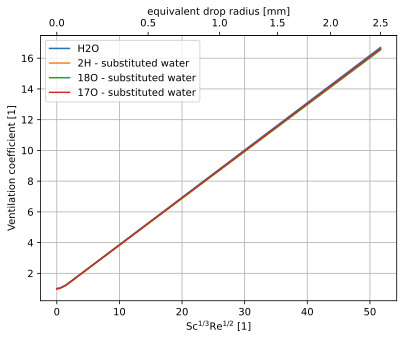

In [6]:
temperature = 273.15 *si.K
radius = np.linspace(0, 2.5, 100) * si.mm
fig, ax = pyplot.subplots(1)
X, vent_coef = f(formulae, radius, temperature)


isotopes = (
    "2H",
    "18O",
    "17O"
)
ax.plot(X, vent_coef, label="H2O")
for isotope in isotopes:
    ax.plot(
        X,
        f_heavy(vent_coef, temperature, isotope=isotope),
        label=f"{isotope} - substituted water"
    )
ax.set_title("")
ax.set_xlabel("Sc$^{1/3}$Re$^{1/2}$ [1]")
ax.set_ylabel("Ventilation coefficient [1]")

ax.legend()
ax2 = ax.secondary_xaxis("top", functions=(
    interp1d(X,in_unit(radius, si.mm), bounds_error=False, fill_value="extrapolate"),
    interp1d(in_unit(radius, si.mm), X, bounds_error=False, fill_value="extrapolate")
))
ax2.set_ticks(np.linspace(0, 5, 11))
ax2.set_xlabel("equivalent drop radius [mm]")
ax.grid()
show_plot("ventilation_coefficient_for_isotopes.pdf")

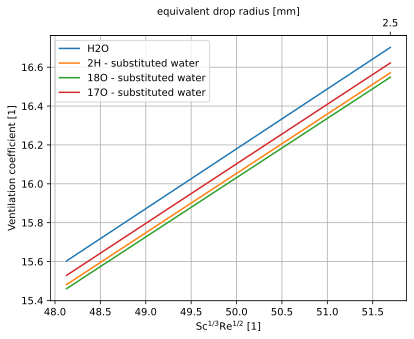

In [7]:
n = 10
fig, ax = pyplot.subplots(1)
ax.plot(X[-n:], vent_coef[-n:], label="H2O")
for isotope in isotopes:
    ax.plot(
        X[-n:],
        f_heavy(vent_coef[-n:], temperature, isotope=isotope),
        label=f"{isotope} - substituted water"
    )
ax.set_title("")
ax.set_xlabel("Sc$^{1/3}$Re$^{1/2}$ [1]")
ax.set_ylabel("Ventilation coefficient [1]")

ax.legend()
ax2 = ax.secondary_xaxis("top", functions=(
    interp1d(X,in_unit(radius, si.mm), bounds_error=False, fill_value="extrapolate"),
    interp1d(in_unit(radius, si.mm), X, bounds_error=False, fill_value="extrapolate")
))
ax2.set_ticks(np.linspace(0, 5, 11))
ax2.set_xlabel("equivalent drop radius [mm]")
ax.grid()
show_plot("ventilation_coefficient_for_isotopes_zoom.pdf")